In [0]:
import numpy as np
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [0]:
import matplotlib.pyplot as plt
import torchvision.transforms as transform

In [0]:
# loading the data
dataset = torchvision.datasets.MNIST('data/',
                                     train=True,
                                     transform=transform.ToTensor(),
                                     download=True)

In [4]:
# inspecting data
img_tensor, label = dataset[0]
print(f"the shape of a sample in the dataset : {img_tensor.shape}")

the shape of a sample in the dataset : torch.Size([1, 28, 28])


Text(0.5, 1.0, '8')

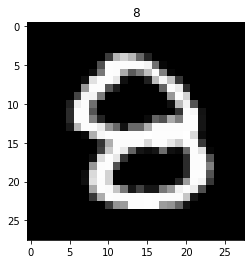

In [5]:
# to plot image tensors
idx = np.random.randint(0,len(dataset))
img_tensor, label = dataset[idx]
plt.imshow(img_tensor[0,:,:], cmap = 'gray')
plt.title(label)

### Spliting the data into train and validation sets

In [0]:
def split_indices(len, val_split):
  split_point = int(len*val_split)
  idxs = np.random.permutation(len)
  return idxs[split_point:], idxs[:split_point]

In [7]:
train_idxs, val_idxs = split_indices(len(dataset), 0.2)
print(f"Number of samples in the training set: {len(train_idxs)}")
print(f"Number of samples in the validation set: {len(val_idxs)}")

Number of samples in the training set: 48000
Number of samples in the validation set: 12000


 To specify which indices to use when using the dataloader function from pytorch.data we use the SubsetRandomSamplet object

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

In [0]:
batch_size = 100

train_sampler = SubsetRandomSampler(train_idxs)
val_sampler = SubsetRandomSampler(val_idxs)

train_dl = DataLoader(dataset, batch_size, sampler=train_sampler)
val_dl = DataLoader(dataset, batch_size, sampler=val_sampler)

### Done with preparing the data
---
Lets Build the model

In [0]:
input_size = 28*28
num_classes = 10

In [0]:
class MnistModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, num_classes)
  
  def forward(self, input_batch):
    input_batch = input_batch.reshape(-1, 28*28)
    out = self.linear(input_batch)
    return out

In [0]:
# okay now lets create a model object
model = MnistModel()

In [13]:
# lets take a look at the shape of the weights and biases and the parameter collections
print(f"Shape of the W matrix : {model.linear.weight.shape}")
print(f"Shape of the b matrix: {model.linear.bias.shape}")
print("\n\n")
print(list(model.parameters()))

Shape of the W matrix : torch.Size([10, 784])
Shape of the b matrix: torch.Size([10])



[Parameter containing:
tensor([[-0.0356,  0.0030, -0.0204,  ...,  0.0057, -0.0338,  0.0333],
        [ 0.0243,  0.0230, -0.0105,  ..., -0.0248,  0.0297, -0.0206],
        [ 0.0324,  0.0347,  0.0128,  ...,  0.0230,  0.0011,  0.0242],
        ...,
        [ 0.0199, -0.0266,  0.0087,  ..., -0.0165, -0.0203,  0.0255],
        [ 0.0197,  0.0039, -0.0144,  ...,  0.0066, -0.0050,  0.0272],
        [ 0.0268, -0.0346, -0.0101,  ...,  0.0276, -0.0178,  0.0042]],
       requires_grad=True), Parameter containing:
tensor([ 0.0170,  0.0259,  0.0028,  0.0182, -0.0290, -0.0317,  0.0153, -0.0232,
         0.0038,  0.0197], requires_grad=True)]


I have explained some theory at the end of this notebook behind the working of the mod

# Training the model, consists of three steps: 
---
- a loss batch function which computes the loss after each batch, with a toggleable optimize option which updates the weights and metric option in case we need to add another metric of evaluation in addtion to loss
- an evaluate function which works with torch.no_grad and computes the avg_loss and other metrics
- Finally a fit function which encapsulates the whole process of fiting on the training data and evaluating on the validation data for each epoch
- (optional: metric defination if required)

In [0]:
def propagate_batch(model, loss_fn, features_batch, labels_batch, opt=None, metric=None):
  preds = model(features_batch)
  loss = loss_fn(preds, labels_batch)

  if metric:
    metric_result = metric(preds, labels_batch)
  else: 
    metric_result = None
  
  if opt:
    loss.backward()
    opt.step()
    opt.zero_grad()
  
  # len is required to find the average of each metric
  return loss.item(), len(labels_batch), metric_result

In [0]:
def evaluate(model, loss_fn, val_dl, metric=None):
  # imp disable autograd to save computation power
  with torch.no_grad():
    results = [propagate_batch(model, loss_fn, features_batch, labels_batch, 
                               opt=None, metric=metric) 
              for features_batch, labels_batch in val_dl]

    losses, lens, metrics = zip(*results)

    total = np.sum(lens)

    avg_loss = np.sum(np.multiply(losses, lens)) / total

    if metric:
      avg_metric = np.sum(np.multiply(metrics, lens)) / total
    else: 
      avg_metric = None
    
    return avg_loss, total, avg_metric

In [0]:
def accuracy(outputs, targets):
  _, preds = torch.max(outputs, dim=1)
  return torch.sum(preds == targets).item() / len(preds)

In [0]:
loss_fn = F.cross_entropy

In [18]:
# test 
val_loss, total, val_acc = evaluate(model, loss_fn, val_dl, metric=accuracy)
print(f"Loss: {val_loss}, Accuracy: {val_acc}")

Loss: 2.3468224585056303, Accuracy: 0.08058333333333334


In [0]:
def fit(epochs, model, loss_fn, opt, train_dl, val_dl, metric=None):
  
  history = {"val_loss" : [],
             "metric": [],
             "epoch": []
             }
  for epoch in range(epochs):

    # Training step
    for features_batch, labels_batch in train_dl:
      loss, _, _ = propagate_batch(model, loss_fn, features_batch, labels_batch,
                                   opt)
    
    # evaluation step
    val_loss, total, val_metric = evaluate(model, loss_fn, val_dl, metric)
    
    # log progress
    history['val_loss'].append(val_loss)
    history['epoch'].append(epoch)
    if metric is None:
      print(f"Epoch: [{epoch+1}/{epochs}], Loss: {val_loss}")
    else:
      history['metric'].append(val_metric)
      print(f"Epoch: [{epoch+1}/{epochs}], Loss: {val_loss}, {metric.__name__}: {val_metric}")

  return history

In [0]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [21]:
history = fit(10, model, F.cross_entropy, optimizer, train_dl, val_dl, accuracy)

Epoch: [1/10], Loss: 1.9050560881694159, accuracy: 0.6441666666666667
Epoch: [2/10], Loss: 1.5975238213936487, accuracy: 0.7570833333333333
Epoch: [3/10], Loss: 1.3815788835287095, accuracy: 0.7843333333333333
Epoch: [4/10], Loss: 1.226641704638799, accuracy: 0.79975
Epoch: [5/10], Loss: 1.1119710887471834, accuracy: 0.8118333333333333
Epoch: [6/10], Loss: 1.0243883172671, accuracy: 0.8195
Epoch: [7/10], Loss: 0.9556464875737826, accuracy: 0.8249166666666666
Epoch: [8/10], Loss: 0.9002589662869771, accuracy: 0.8313333333333334
Epoch: [9/10], Loss: 0.8546782597899437, accuracy: 0.83625
Epoch: [10/10], Loss: 0.816401910285155, accuracy: 0.8391666666666666


In [23]:
history.keys()

dict_keys(['val_loss', 'metric', 'epoch'])

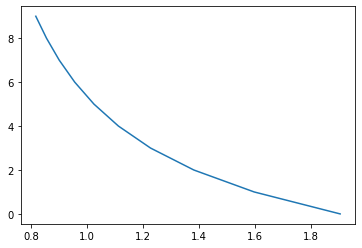

In [25]:
plt.plot(history['val_loss'], history['epoch'])
plt.show()

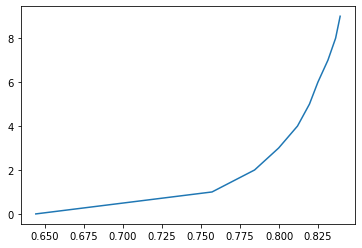

In [26]:
plt.plot(history['metric'], history['epoch'])
plt.show()

In [0]:
# looks like we are still improving lets train for longer
history = fit(10, model, F.cross_entropy, optimizer, train_dl, val_dl, accuracy)

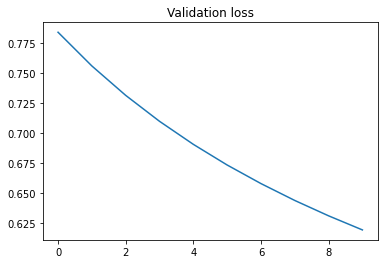

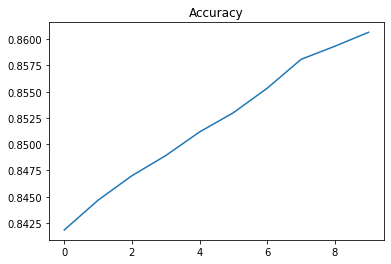

In [29]:
plt.plot(history['epoch'], history['val_loss'])
plt.title('Validation loss')
plt.show()
plt.plot(history['epoch'], history['metric'])
plt.title('Accuracy')
plt.show()

Epoch: [1/20], Loss: 0.600577158977588, accuracy: 0.8629166666666667
Epoch: [2/20], Loss: 0.5911727550129096, accuracy: 0.8636666666666667
Epoch: [3/20], Loss: 0.5824525428315004, accuracy: 0.8648333333333333
Epoch: [4/20], Loss: 0.5743317663669586, accuracy: 0.8655833333333334
Epoch: [5/20], Loss: 0.5667278006672859, accuracy: 0.8669166666666667
Epoch: [6/20], Loss: 0.5596019883950551, accuracy: 0.8679166666666667
Epoch: [7/20], Loss: 0.5529036785165469, accuracy: 0.8685833333333334
Epoch: [8/20], Loss: 0.5465952803691229, accuracy: 0.8694166666666666
Epoch: [9/20], Loss: 0.5406507737934589, accuracy: 0.8700833333333333
Epoch: [10/20], Loss: 0.5350171556075414, accuracy: 0.8713333333333333
Epoch: [11/20], Loss: 0.5296776582797368, accuracy: 0.873
Epoch: [12/20], Loss: 0.5246163609127203, accuracy: 0.8734166666666666
Epoch: [13/20], Loss: 0.5198011939724286, accuracy: 0.8740833333333333
Epoch: [14/20], Loss: 0.5152111279467742, accuracy: 0.875
Epoch: [15/20], Loss: 0.5108385421335697, 

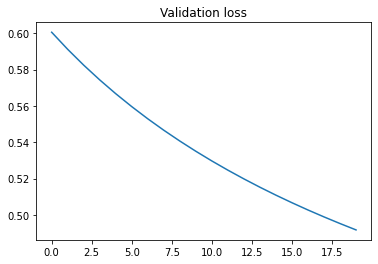

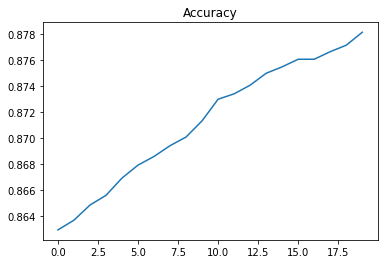

In [31]:
# We are stil improving lets train for longer:
history3 = fit(20, model, F.cross_entropy, optimizer, train_dl, val_dl, accuracy)
plt.plot(history3['epoch'], history3['val_loss'])
plt.title('Validation loss')
plt.show()
plt.plot(history3['epoch'], history3['metric'])
plt.title('Accuracy')
plt.show()

In [0]:
# trying out the testdataset
test_dataset = torchvision.datasets.MNIST(root='data/',
                                          train=False,
                                          download=True,
                                          transform=transform.ToTensor())

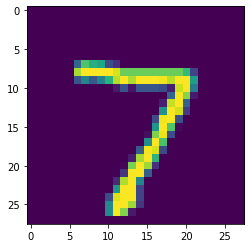

In [34]:
img, label = test_dataset[0]
plt.imshow(img[0])

In [0]:
def predict_img(img, model):
  features = img.unsqueeze(0)
  output = model(features)
  _, preds = torch.max(output, dim=1)
  return preds.item()

Text(0.5, 1.0, 'True label 8, Prediction: 8')

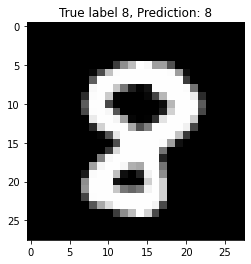

In [48]:
# to plot image tensors
idx = np.random.randint(0,len(test_dataset))
img_tensor, label = test_dataset[idx]
plt.imshow(img_tensor[0], cmap = 'gray')
plt.title(f"True label {label}, Prediction: {predict_img(img_tensor, model)}")

In [51]:
test_dl = DataLoader(test_dataset, batch_size=100)
test_loss, total, test_acc = evaluate(model, loss_fn, test_dl, metric=accuracy)
print(f"Loss: {test_loss}\nAccuracy: {test_acc}")

Loss: 0.4712366750091314
Accuracy: 0.8853


In [0]:
# saving the model
torch.save(model.state_dict(), "mnist-lr-88acc.pth")

In [53]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0356,  0.0030, -0.0204,  ...,  0.0057, -0.0338,  0.0333],
                      [ 0.0243,  0.0230, -0.0105,  ..., -0.0248,  0.0297, -0.0206],
                      [ 0.0324,  0.0347,  0.0128,  ...,  0.0230,  0.0011,  0.0242],
                      ...,
                      [ 0.0199, -0.0266,  0.0087,  ..., -0.0165, -0.0203,  0.0255],
                      [ 0.0197,  0.0039, -0.0144,  ...,  0.0066, -0.0050,  0.0272],
                      [ 0.0268, -0.0346, -0.0101,  ...,  0.0276, -0.0178,  0.0042]])),
             ('linear.bias',
              tensor([-0.0462,  0.1757, -0.0330, -0.0350,  0.0181,  0.0788, -0.0017,  0.0588,
                      -0.1852, -0.0116]))])

In [55]:
# extra
# to load state dict
model2 = MnistModel()
model2.load_state_dict(torch.load("mnist-lr-88acc.pth"))

<All keys matched successfully>

In [56]:
# check
test_loss, total, test_acc = evaluate(model2, loss_fn, test_dl, metric=accuracy)
print(f"Loss: {test_loss}\nAccuracy: {test_acc}")

Loss: 0.4712366750091314
Accuracy: 0.8853
